# simdkalmanの実装

# ドキュメント
# https://pypi.org/project/simdkalman/
# 関連論文
# https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

In [196]:
import os
import sys
import time
import math
import random
from random import randint

import glob
import numpy as np
import pandas as pd

import statsmodels.api as sm
import simdkalman

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [197]:
path = "/Users/kushi/TechLife/free_dataset/ECG_data"
list_data = glob.glob(path + "/**.txt")
list_data

['/Users/kushi/TechLife/free_dataset/ECG_data\\chfdb_chf01_275.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\chfdb_chf13_45590.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\ltstdb_20221_43.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\ltstdb_20321_240.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\mitdb__100_180.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\stdb_308_0.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\xmitdb_x108_0.txt']

In [198]:
df_opening = pd.read_csv(list_data[0], sep="\t", names=["aa","bb","cc"])
print(df_opening.shape)
df_opening.head(10)

(3751, 3)


,aa,bb,cc
0,275.000,-0.645,0.665
1,275.004,-0.635,0.710
2,275.008,-0.645,0.745
3,275.012,-0.635,0.760
4,275.016,-0.645,0.785
5,275.020,-0.630,0.790
6,275.024,-0.630,0.815
7,275.028,-0.635,0.835
8,275.032,-0.625,0.860
9,275.036,-0.645,0.870


(1, 3751)


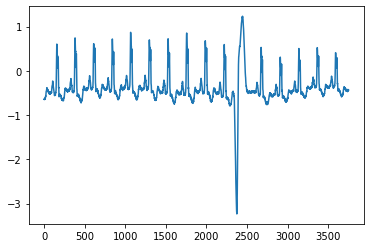

In [199]:
df_ = df_opening.iloc[:, 1:2]
data_np_ = np.array(df_)
data_np_ = data_np_.reshape(1, data_np_.shape[0])
print(data_np_.shape)
plt.plot(data_np_.T)

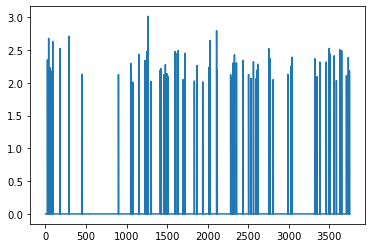

In [200]:
# ノイズを加えてみる(電気ノイズみたいな圧倒的な外れ値に対する性能確認)
nois = np.random.normal(size=(1, data_np.shape[1]))
nois = np.where(nois<2, 0, nois)
plt.plot(nois.T)

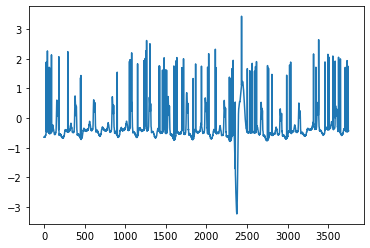

In [201]:
data_np = data_np_ + nois
plt.plot(data_np.T)

# simdkalman

In [202]:
# スムーサーの精度を向上させるためには、共分散値を振ってみるとよさそう
# Qを小さくする(0.01,0.001)と高速で低精度、大きくするとスムーズにできない。。。
# このチューニングが難しそう

kf = simdkalman.KalmanFilter(
    state_transition = [[1,1],[0,1]],        # matrix A
    process_noise = np.diag([0.1, 0.001]),    # Q[0.01, 0.001]
    observation_model = np.array([[1, 0.2]]),   # H[1, 0]
    observation_noise = 1.0)                 # R[1.0]

In [203]:
%%time
print(data_np.shape)

# EMアルゴリズムを使い、ノイズに適合させる？(最尤推定、期待値最大化法)
#kf = kf.em(data_np, n_iter=1000)
#kf = kf.em(data_np, 10)

# スムージング
smoothed = kf.smooth(data_np)

# 予測
pred = kf.predict(data_np, 150)

(1, 3751)
Wall time: 875 ms


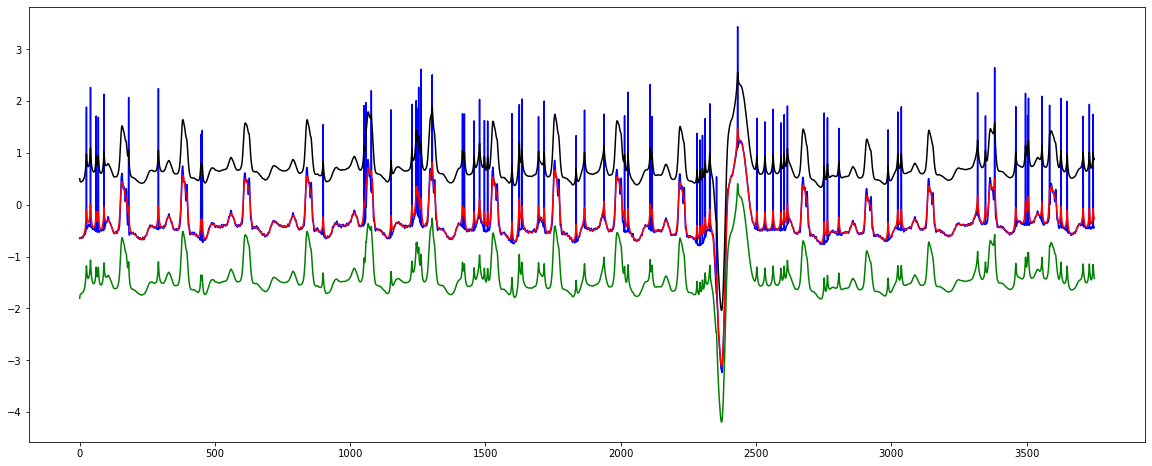

In [204]:
st = 0
fi = 500

fig = plt.figure(figsize=(20, 8))

smoothed_obs = smoothed.observations.mean[0]
obs_stdev = np.sqrt(smoothed.observations.cov[0])

plt.plot(data_np.T, c="blue")
plt.plot(smoothed_obs, c="red")
plt.plot(smoothed_obs - obs_stdev, c="green")
plt.plot(smoothed_obs + obs_stdev, c="black")

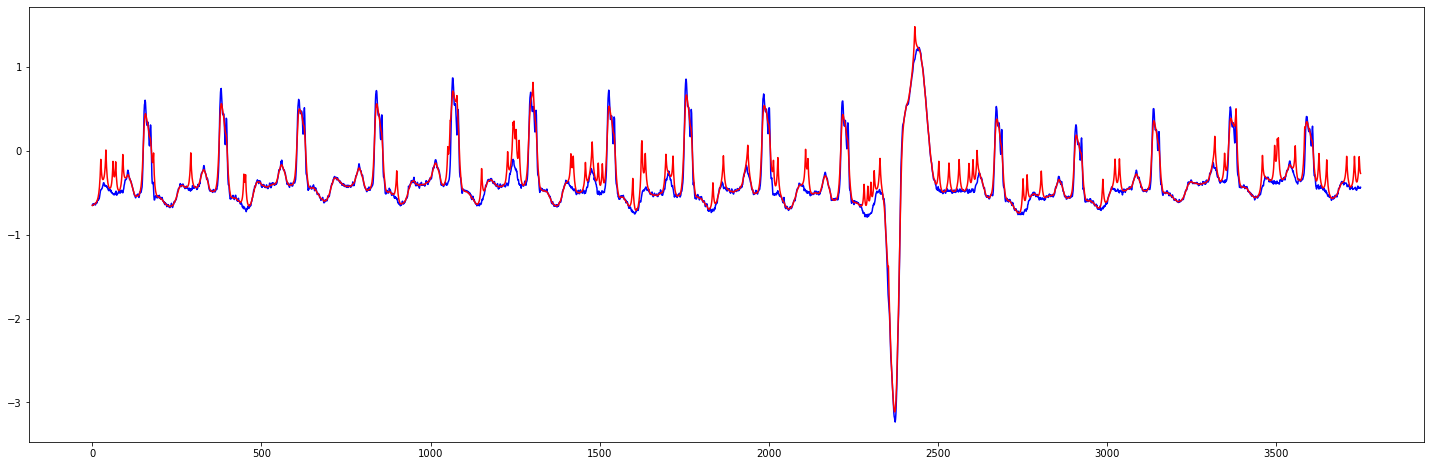

In [205]:
fig = plt.figure(figsize=(25, 8))
#plt.plot(data_np.T, c="blue")
plt.plot(df_, c="blue")
plt.plot(smoothed_obs, c="red")


In [206]:
# 新たな次ステップに対する予測した観測結果を取得する
x_pred = np.arange(data_np.shape[1], data_np.shape[1]+pred.observations.mean.shape[1])
y_pred = pred.observations.mean[i,:]
pred_stdev = np.sqrt(pred.observations.cov[0,:])
ax1.plot(x_pred, y_pred, 'b-', label="predicted")
ax1.plot(x_pred, y_pred + pred_stdev, 'k--')
ax1.plot(x_pred, y_pred - pred_stdev, 'k--')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

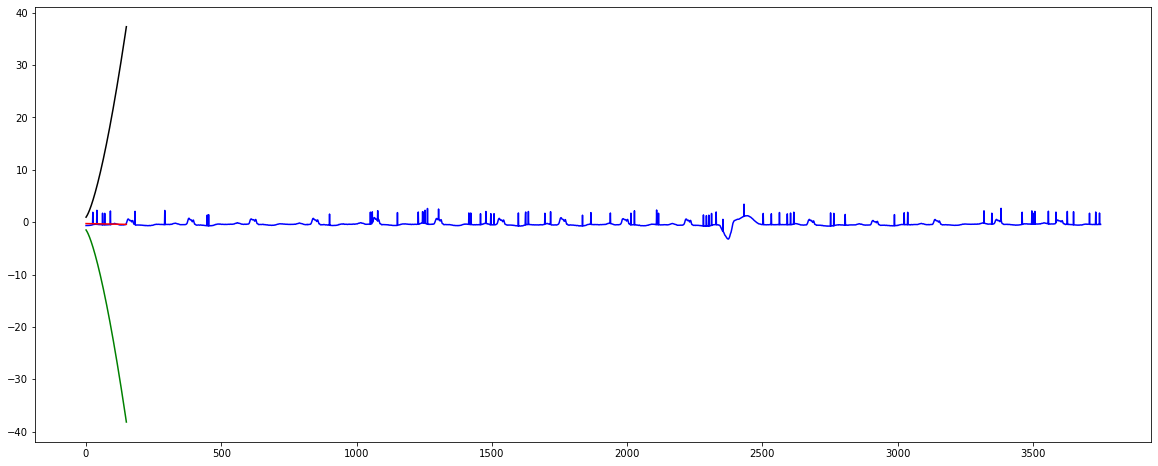

In [207]:
#st = 0
#fi = 500

fig = plt.figure(figsize=(20, 8))

# スムーサー
#smoothed_obs = smoothed.observations.mean[0]
#obs_stdev = np.sqrt(smoothed.observations.cov[0])

# 予測
x_pred = np.arange(data_np.shape[1], data_np.shape[1]+pred.observations.mean.shape[1])
y_pred = pred.observations.mean[0,:]
pred_stdev = np.sqrt(pred.observations.cov[0,:])

plt.plot(data_np.T, c="blue")
plt.plot(y_pred, c="red")
plt.plot(y_pred - pred_stdev, c="green")
plt.plot(y_pred + pred_stdev, c="black")

In [208]:
# 考察_210619

#カルマンフィルタに予測は未確認
#高速なスムーサーにはなるので、低精度でも問題ない場合の手段としては有効
#元の波形形状に大きく影響を及ぼすので、最適化について学ぶ必要がある

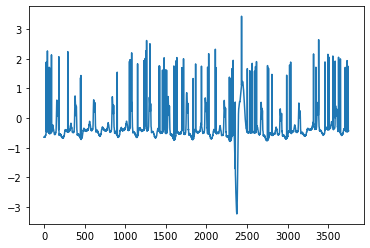

In [209]:
plt.plot(data_np.T)

In [296]:
# ベースライン推定
import csv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse import spdiags
import scipy.sparse.linalg as spla

#パラメタを入力します、うまく推定ができないときはここをいじってください
#AsLSでのベースライン推定は ( W(p) + lam*D'D )z = Wy のとき、重み p と罰則項の係数 lam がパラメタです
#Savitzky-Golyでは、測定値をいくつに分割するかを dn で設定し（窓の数は len(Y)/dn になります)、多項式次数を poly で設定します
# paramAsLS = [ lam , p ]
# paramSG   = [ dn , poly ]
#paramAsLS = [10**3.5, 0.00005]
paramAsLS = [0.2**3.5, 0.00005]
paramSG = [80, 5]

In [297]:
gg = np.array(data_np.T).reshape(-1)
#plt.plot(gg)
#gg.reshape(-1)

In [298]:
#AsLSによりベースライン推定を行います

def baseline_als(y, lam, p, niter=10):
    #https://stackoverflow.com/questions/29156532/python-baseline-correction-library
    #p: 0.001 - 0.1, lam: 10^2 - 10^9
    # Baseline correction with asymmetric least squares smoothing, P. Eilers, 2005
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spla.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [299]:
%%time
#実行します
#outFigCSV(X,Y,paramAsLS, paramSG)
#bkg = baseline_als(Y_np,paramAsLS[0], paramAsLS[1])
bkg = baseline_als(gg, paramAsLS[0], paramAsLS[1])

Wall time: 236 ms


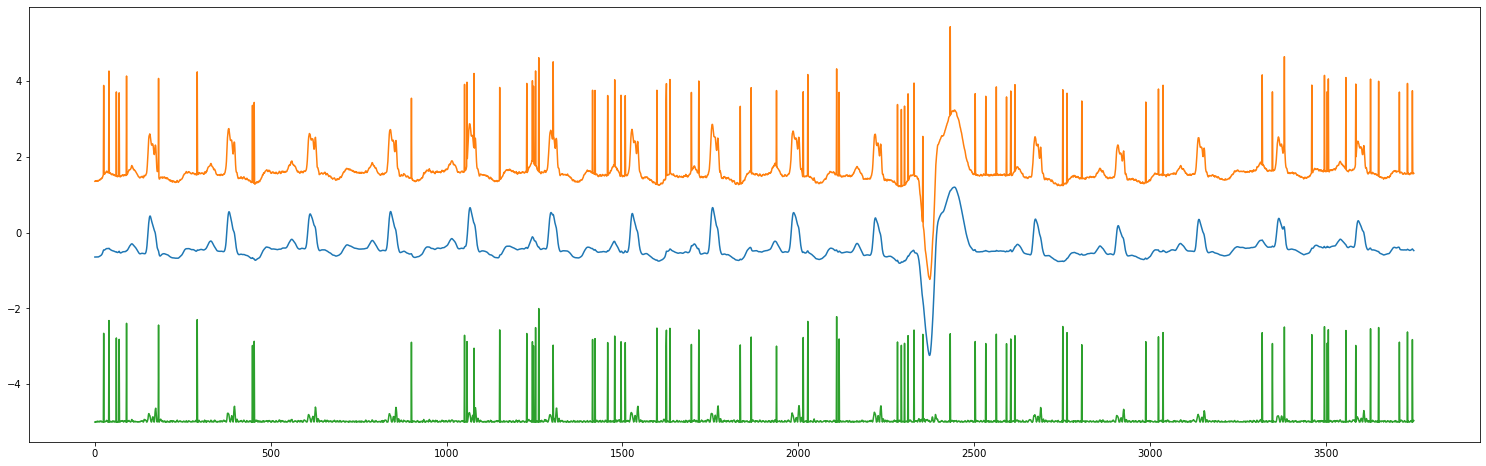

In [300]:
fig = plt.figure(figsize=(26,8))
plt.plot(bkg)
plt.plot(gg + 2)
plt.plot((gg - bkg) - 5)


In [210]:
# Hampel-identifierを使ったフィルタ
# データを窓サイズで部分時系列に区分けして、3σ法で外れ値（スパイク）をスムージングする

# ニーズ：標準化する際に平均値や標準偏差が外れ値の影響を大きく受けるため、ロバストな統計量を用いて外れ値除去をする
# 平均値を中央値に、標準偏差を中央絶対偏差 * 1.4826にすることで、ロバストな標準化ができる
# 閾値は、中央値 ±3 * 1.4826 * 中央絶対偏差
# 正規分布を仮定

def Hampel(x, k=5, thr=3):
    
    """Hampel-identifier-filter(Divide the data into partial time series by window size and detect outliers (spike) by the 3σ method)
    
    Parameters:
    ----------
    x : pandas.DataFrame or pandas-Series
    k : window size(sumple value)
    thr : sigma number used in this method
    
    Returns:
    ----------
    dict
    """
    
    arraySize = len(x)
    idx = np.arange(arraySize)
    output_x = x.copy()
    output_Idx = np.zeros_like(x)
    
    # 
    for i in range(arraySize):
        mask1 = np.where( idx >= (idx[i] - k) ,True, False)
        mask2 = np.where( idx <= (idx[i] + k) ,True, False)
        kernel = np.logical_and(mask1, mask2)
        median = np.median(x[kernel])
        
        # 正規分布に従うデータのときに、標準偏差に等しくなるよう補正するための係数が1.4826
        # 標準偏差の代わりに使うときには、中央絶対偏差* 1.4826の係数で補正する必要がある
        std = 1.4826 * np.median(np.abs(x[kernel] - median))
        
        '''
        print("mask1 =", mask1)
        print("mask2 =", mask2)
        print("kernel =", kernel.astype(int))
        print("x[kernel] =", x[kernel])
        print("median =", median)
        print("std =", std)
        print("")
        '''
        
        if np.abs(x[i] - median) > thr * std:
            # 外れ値サンプルのインデックスに1を代入する
            output_Idx[i] = 1
            # カーネル内の中央値で補完する(平滑化)
            output_x[i] = median
 
    # return output_x, output_Idx.astype(bool)
    return output_x, output_Idx
 

In [219]:
%%time
# hampelフィルタを実行する
output_x, output_Idx = Hampel(data_np.T, 5, 3)

Wall time: 400 ms


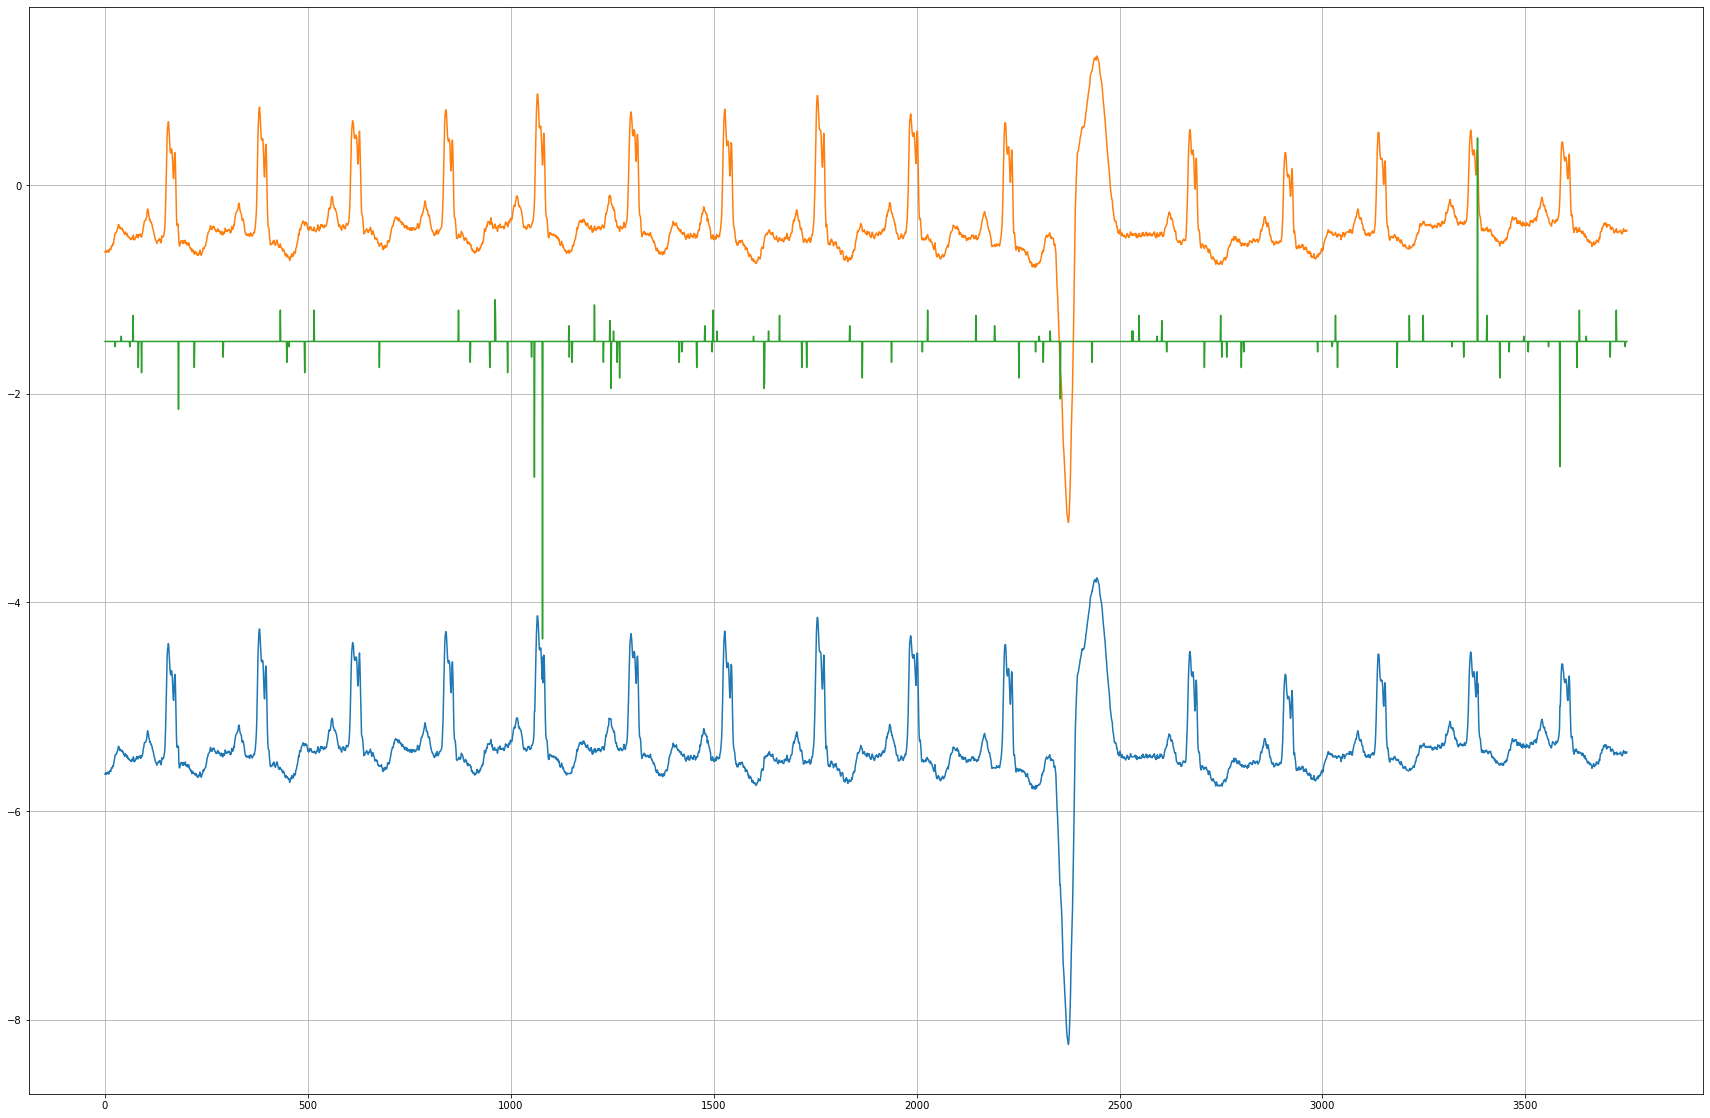

In [236]:
# ノイズ付与前のデータと重ね合わせてみる
fig = plt.figure(figsize=(30, 20))#plt.plot(output_x)
plt.plot(output_x-5)
plt.plot(data_np_.T)
plt.plot(((data_np_.T - output_x)-0.15)*10)
plt.grid()

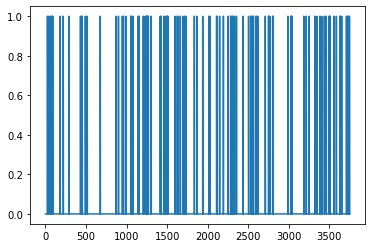

In [213]:
plt.plot(output_Idx)